In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import bilby
import ptemcee

from toy import (
    SimpleGaussianLikelihood, GeneralizedNormalLikelihood, sample_generalized_gaussian,
    alpha_to_sigma, sigma_to_alpha,
    temper_posterior_weights, plot_tempered_posterior_weights, generate_ptemcee_pos0,
    plot_posterior_predictive_distribution
)

from util import HYBRID_COLOR, COMP_COLOR, HYBRID_INIT_COLOR, HYBRID_EVOL_COLORS, plot_single_evolution

plt.style.use("./tgr-hybrid-sampling.mplstyle")

%load_ext autoreload
%autoreload 2

# Misspecified Model

In [2]:
N = 10000
mu_true = 3
alpha_true = 5
beta_true = 8
sigma_true = alpha_to_sigma(alpha_true, beta = 8)

data = sample_generalized_gaussian(mu_true, alpha_true, beta_true, N)

## First Step - Dynesty

In [3]:
label = "misspecified_dynesty-step"
outdir = "./misspecified/misspecified_dynesty-step" 

gaussian_likelihood = SimpleGaussianLikelihood(data)
priors = dict(
    mu=bilby.core.prior.Uniform(0, 5, 'mu'),
    sigma=bilby.core.prior.Uniform(0, 10, 'sigma'),
)

nlive = 500

# And run sampler
result_hybrid_nest = bilby.run_sampler(
    likelihood=gaussian_likelihood, priors=priors, sampler='dynesty', npoints=nlive,
    walks=10, outdir=outdir, label=label)

08:20 bilby INFO    : Running for label 'misspecified_dynesty-step', output will be saved to './misspecified/misspecified_dynesty-step'
08:20 bilby INFO    : Search parameters:
08:20 bilby INFO    :   mu = Uniform(minimum=0, maximum=5, name='mu', latex_label='mu', unit=None, boundary=None)
08:20 bilby INFO    :   sigma = Uniform(minimum=0, maximum=10, name='sigma', latex_label='sigma', unit=None, boundary=None)
08:20 bilby INFO    : Single likelihood evaluation took 1.037e-04 s


0it [00:00, ?it/s]

08:20 bilby INFO    : Checkpoint every check_point_delta_t = 600s
08:20 bilby WARNING : Using cached result
08:20 bilby INFO    : Summary of results:
nsamples: 6564
ln_noise_evidence:    nan
ln_evidence: -24499.320 +/-  0.187
ln_bayes_factor:    nan +/-  0.187



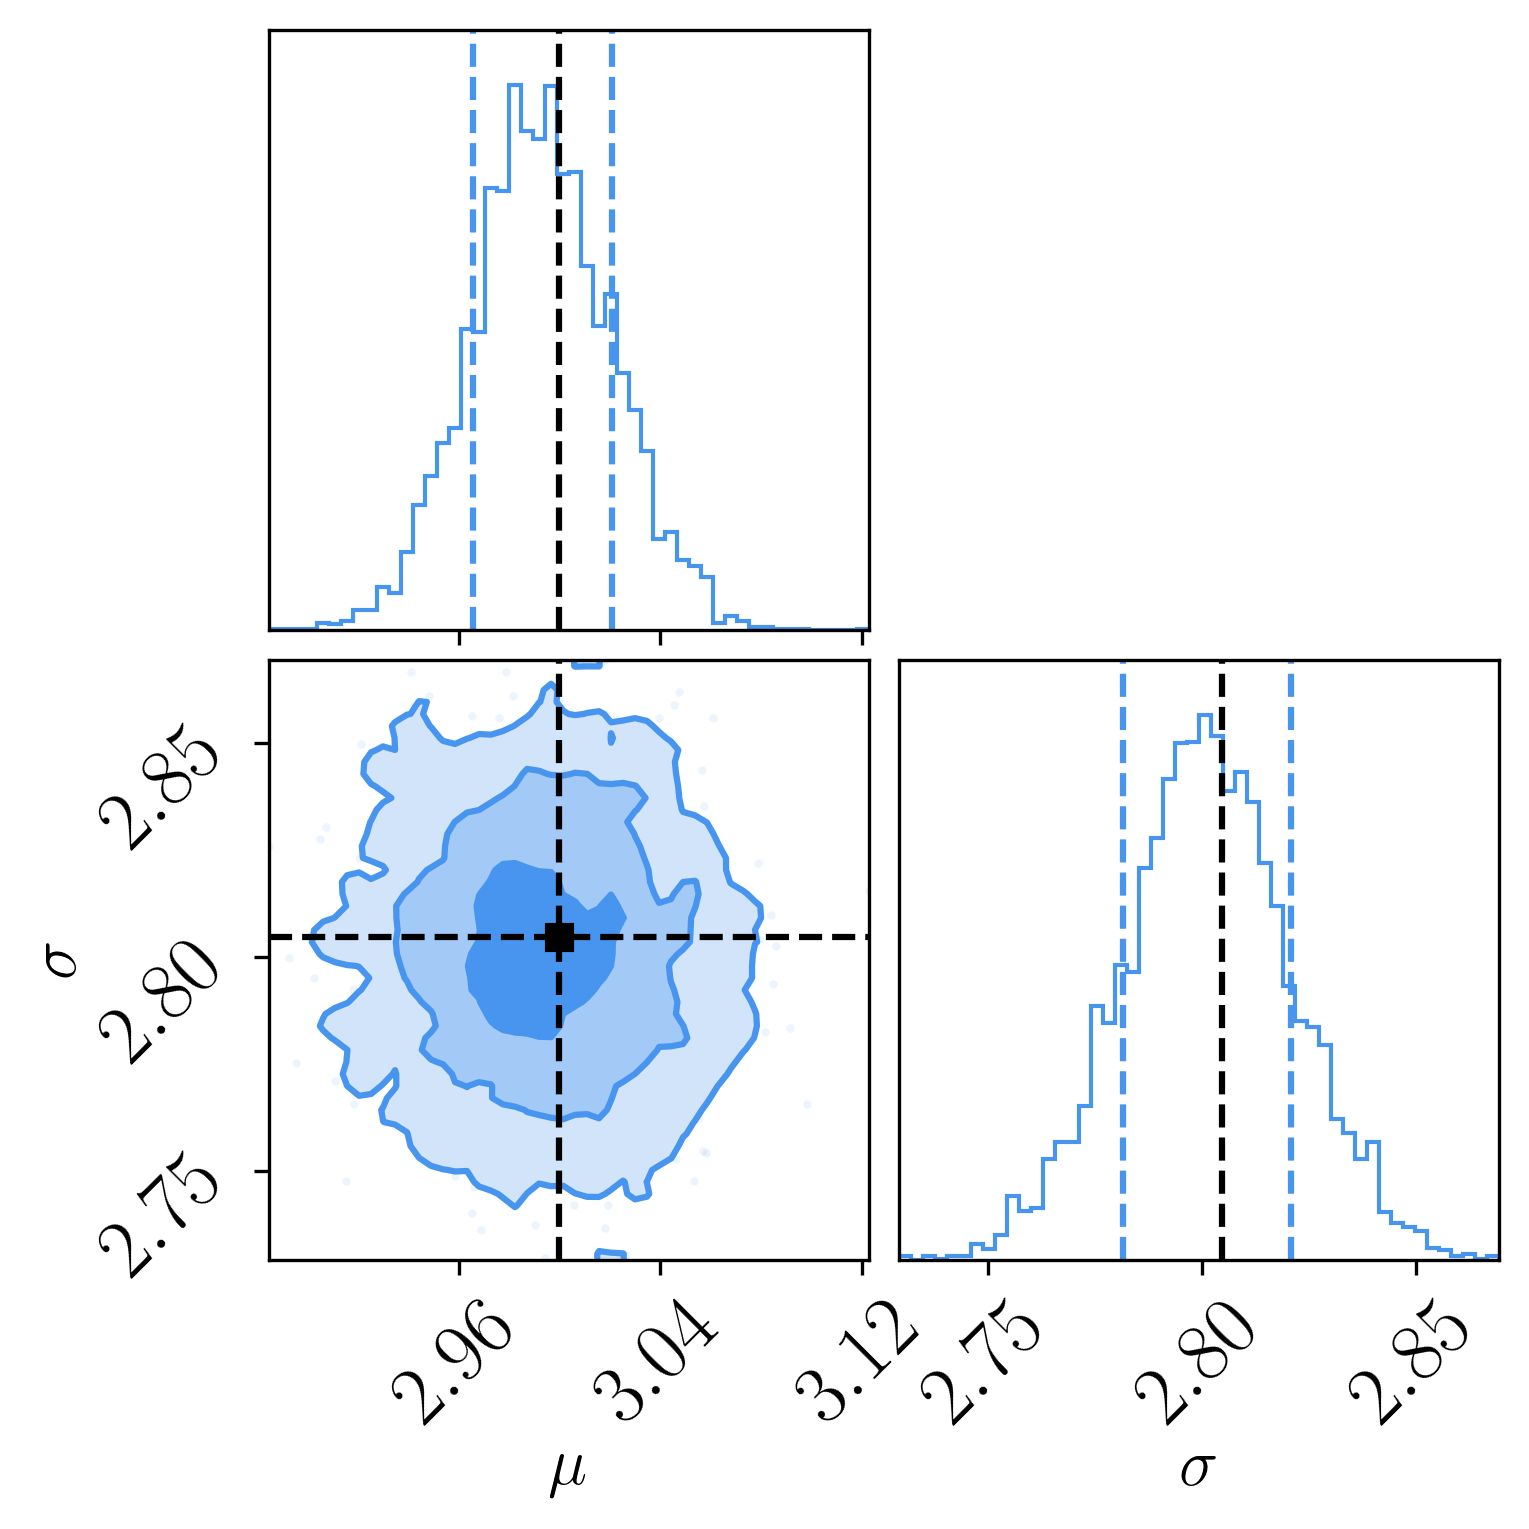

In [4]:
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = result_hybrid_nest.plot_corner(
        parameters=dict(
            mu=mu_true,
            sigma=alpha_to_sigma(alpha_true, beta=beta_true)
        ),
        titles=False,
        labels=[r"$\mu$", r"$\sigma$"],
        color=COMP_COLOR,
        truth_color="black",
        dpi=80
    )

fig

## Second Step - ptemcee

### Setup Tempered Initial Points

In [5]:
label_pt = "misspecified_ptemcee-step"
outdir_pt = "./misspecified/misspecified_ptemcee-step"

ndims    = 3   # 3 dimensions i.e. parameters, {mu, alpha, beta}
nwalkers = 200 # number of walkers in our ensemble
ntemps   = 7   # number of temperatures in our ensemble

# generate the temperatures in our ensemble
beta_T = ptemcee.default_beta_ladder(
    ndim=ndims,            
    ntemps=ntemps,
    Tmax=None
)

In [6]:
nested_samples = result_hybrid_nest.nested_samples

tempered_posterior_weights = temper_posterior_weights(
    nlive = nlive, 
    log_likelihood = nested_samples["log_likelihood"].values, 
    beta_T = beta_T
)

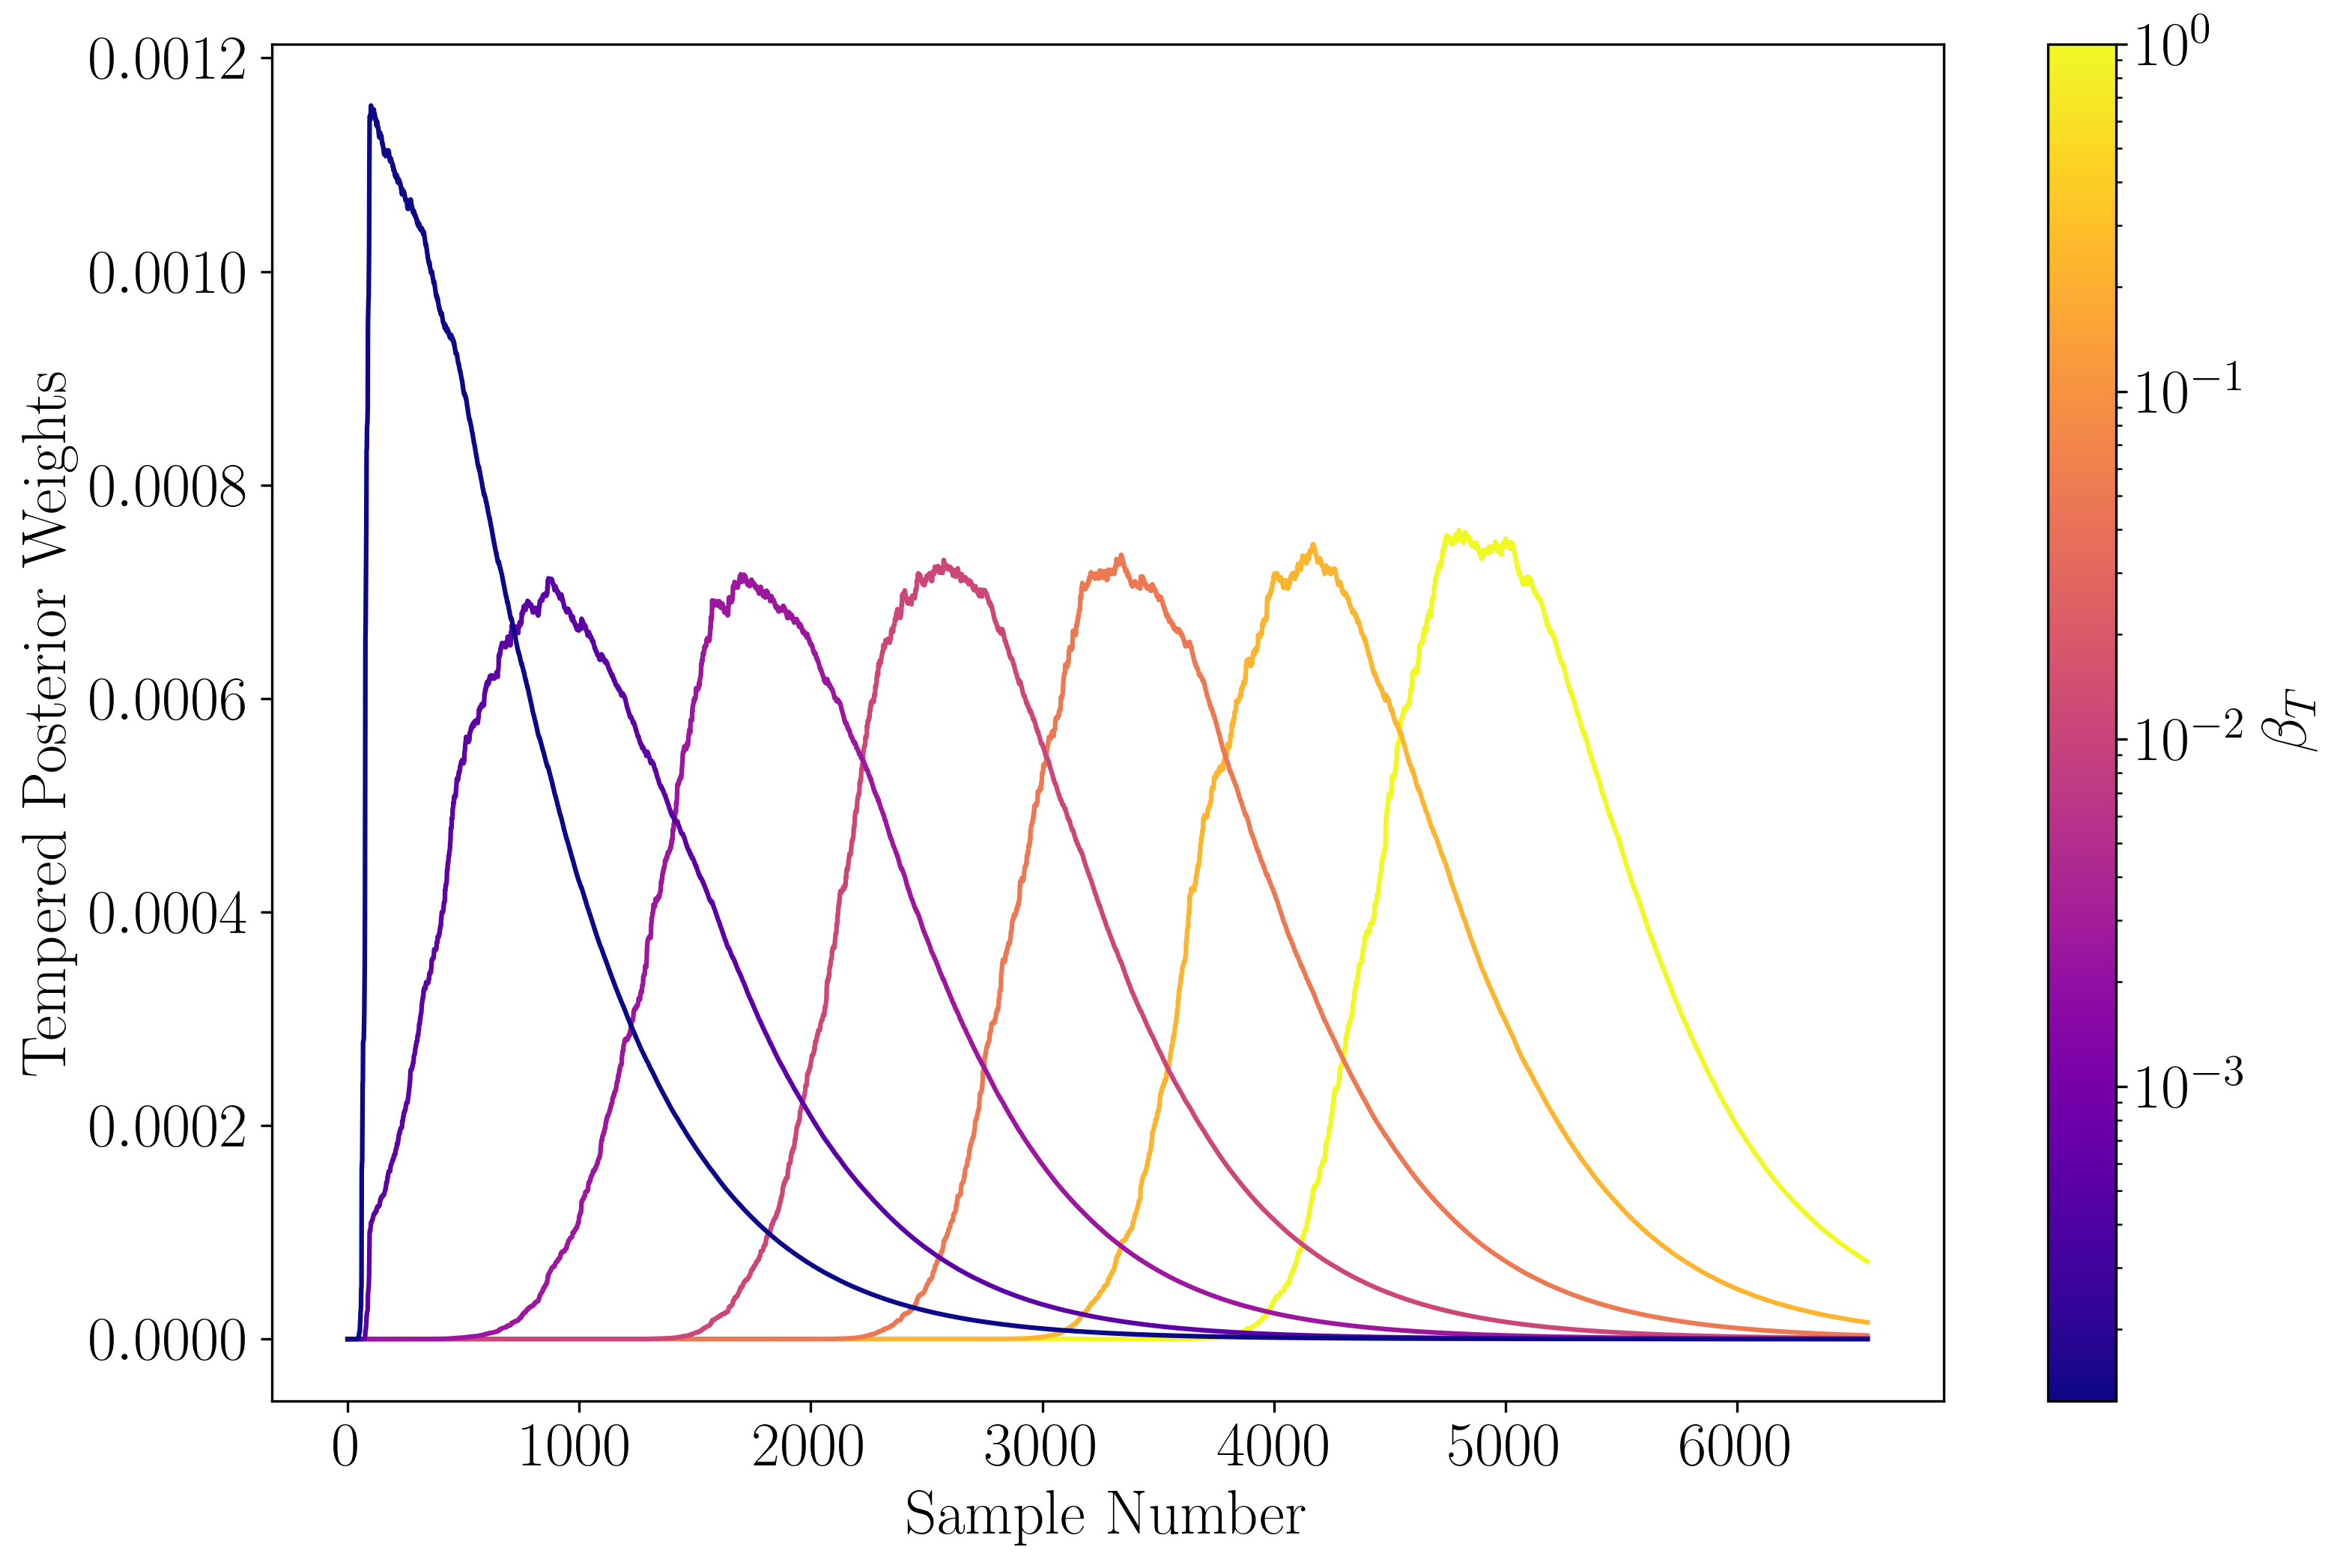

In [7]:
# replicates paper figure with smaller N of data, ~1000 !
with plt.rc_context({'figure.figsize' : (12, 8)}):
    plot_tempered_posterior_weights(
        beta_T = beta_T,
        tempered_posterior_weights = tempered_posterior_weights
)

In [8]:
pos0 = generate_ptemcee_pos0(
    ntemps = ntemps,
    nwalkers = nwalkers,
    ndims = ndims,
    tempered_posterior_weights = tempered_posterior_weights,
    nested_samples = nested_samples
)

In [9]:
generalized_gaussian_likelihood = GeneralizedNormalLikelihood(data)

priors_pt = dict(
    mu=bilby.core.prior.Uniform(minimum=0,maximum=5, latex_label=r"$\mu$"),
    alpha=bilby.core.prior.Uniform(minimum=0,maximum=10 * np.sqrt(2), latex_label=r"$\alpha$"),
    beta=bilby.core.prior.Uniform(minimum=0,maximum=10, latex_label=r"$\beta$")
)

result_hybrid_pt = bilby.run_sampler(
    likelihood=generalized_gaussian_likelihood, 
    pos0     = pos0, 
    priors   = priors_pt, 
    outdir   = outdir_pt,
    ntemps   = ntemps,
    betas    = beta_T,
    nwalkers = nwalkers,
    label    = label_pt, 
    sampler  = 'ptemcee',
    npool    = 4
)

08:20 bilby INFO    : Running for label 'misspecified_ptemcee-step', output will be saved to './misspecified/misspecified_ptemcee-step'
08:20 bilby INFO    : Search parameters:
08:20 bilby INFO    :   mu = Uniform(minimum=0, maximum=5, name=None, latex_label='$\\mu$', unit=None, boundary=None)
08:20 bilby INFO    :   alpha = Uniform(minimum=0, maximum=14.142135623730951, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
08:20 bilby INFO    :   beta = Uniform(minimum=0, maximum=10, name=None, latex_label='$\\beta$', unit=None, boundary=None)
08:20 bilby INFO    : Single likelihood evaluation took 4.196e-04 s
08:20 bilby WARNING : Supplied argument 'npool' not an argument of 'Ptemcee', removing.
08:20 bilby INFO    : Using convergence inputs: ConvergenceInputs(autocorr_c=5, autocorr_tol=50, autocorr_tau=1, gradient_tau=0.1, gradient_mean_log_posterior=0.1, Q_tol=1.02, safety=1, burn_in_nact=50, burn_in_fixed_discard=0, mean_logl_frac=0.01, thin_by_nact=0.5, nsamples=5000, ign

0it [00:10, ?it/s]


08:20 bilby INFO    : Summary of results:
nsamples: 25600
ln_noise_evidence:    nan
ln_evidence: -23675.611 +/- 17.950
ln_bayes_factor:    nan +/- 17.950



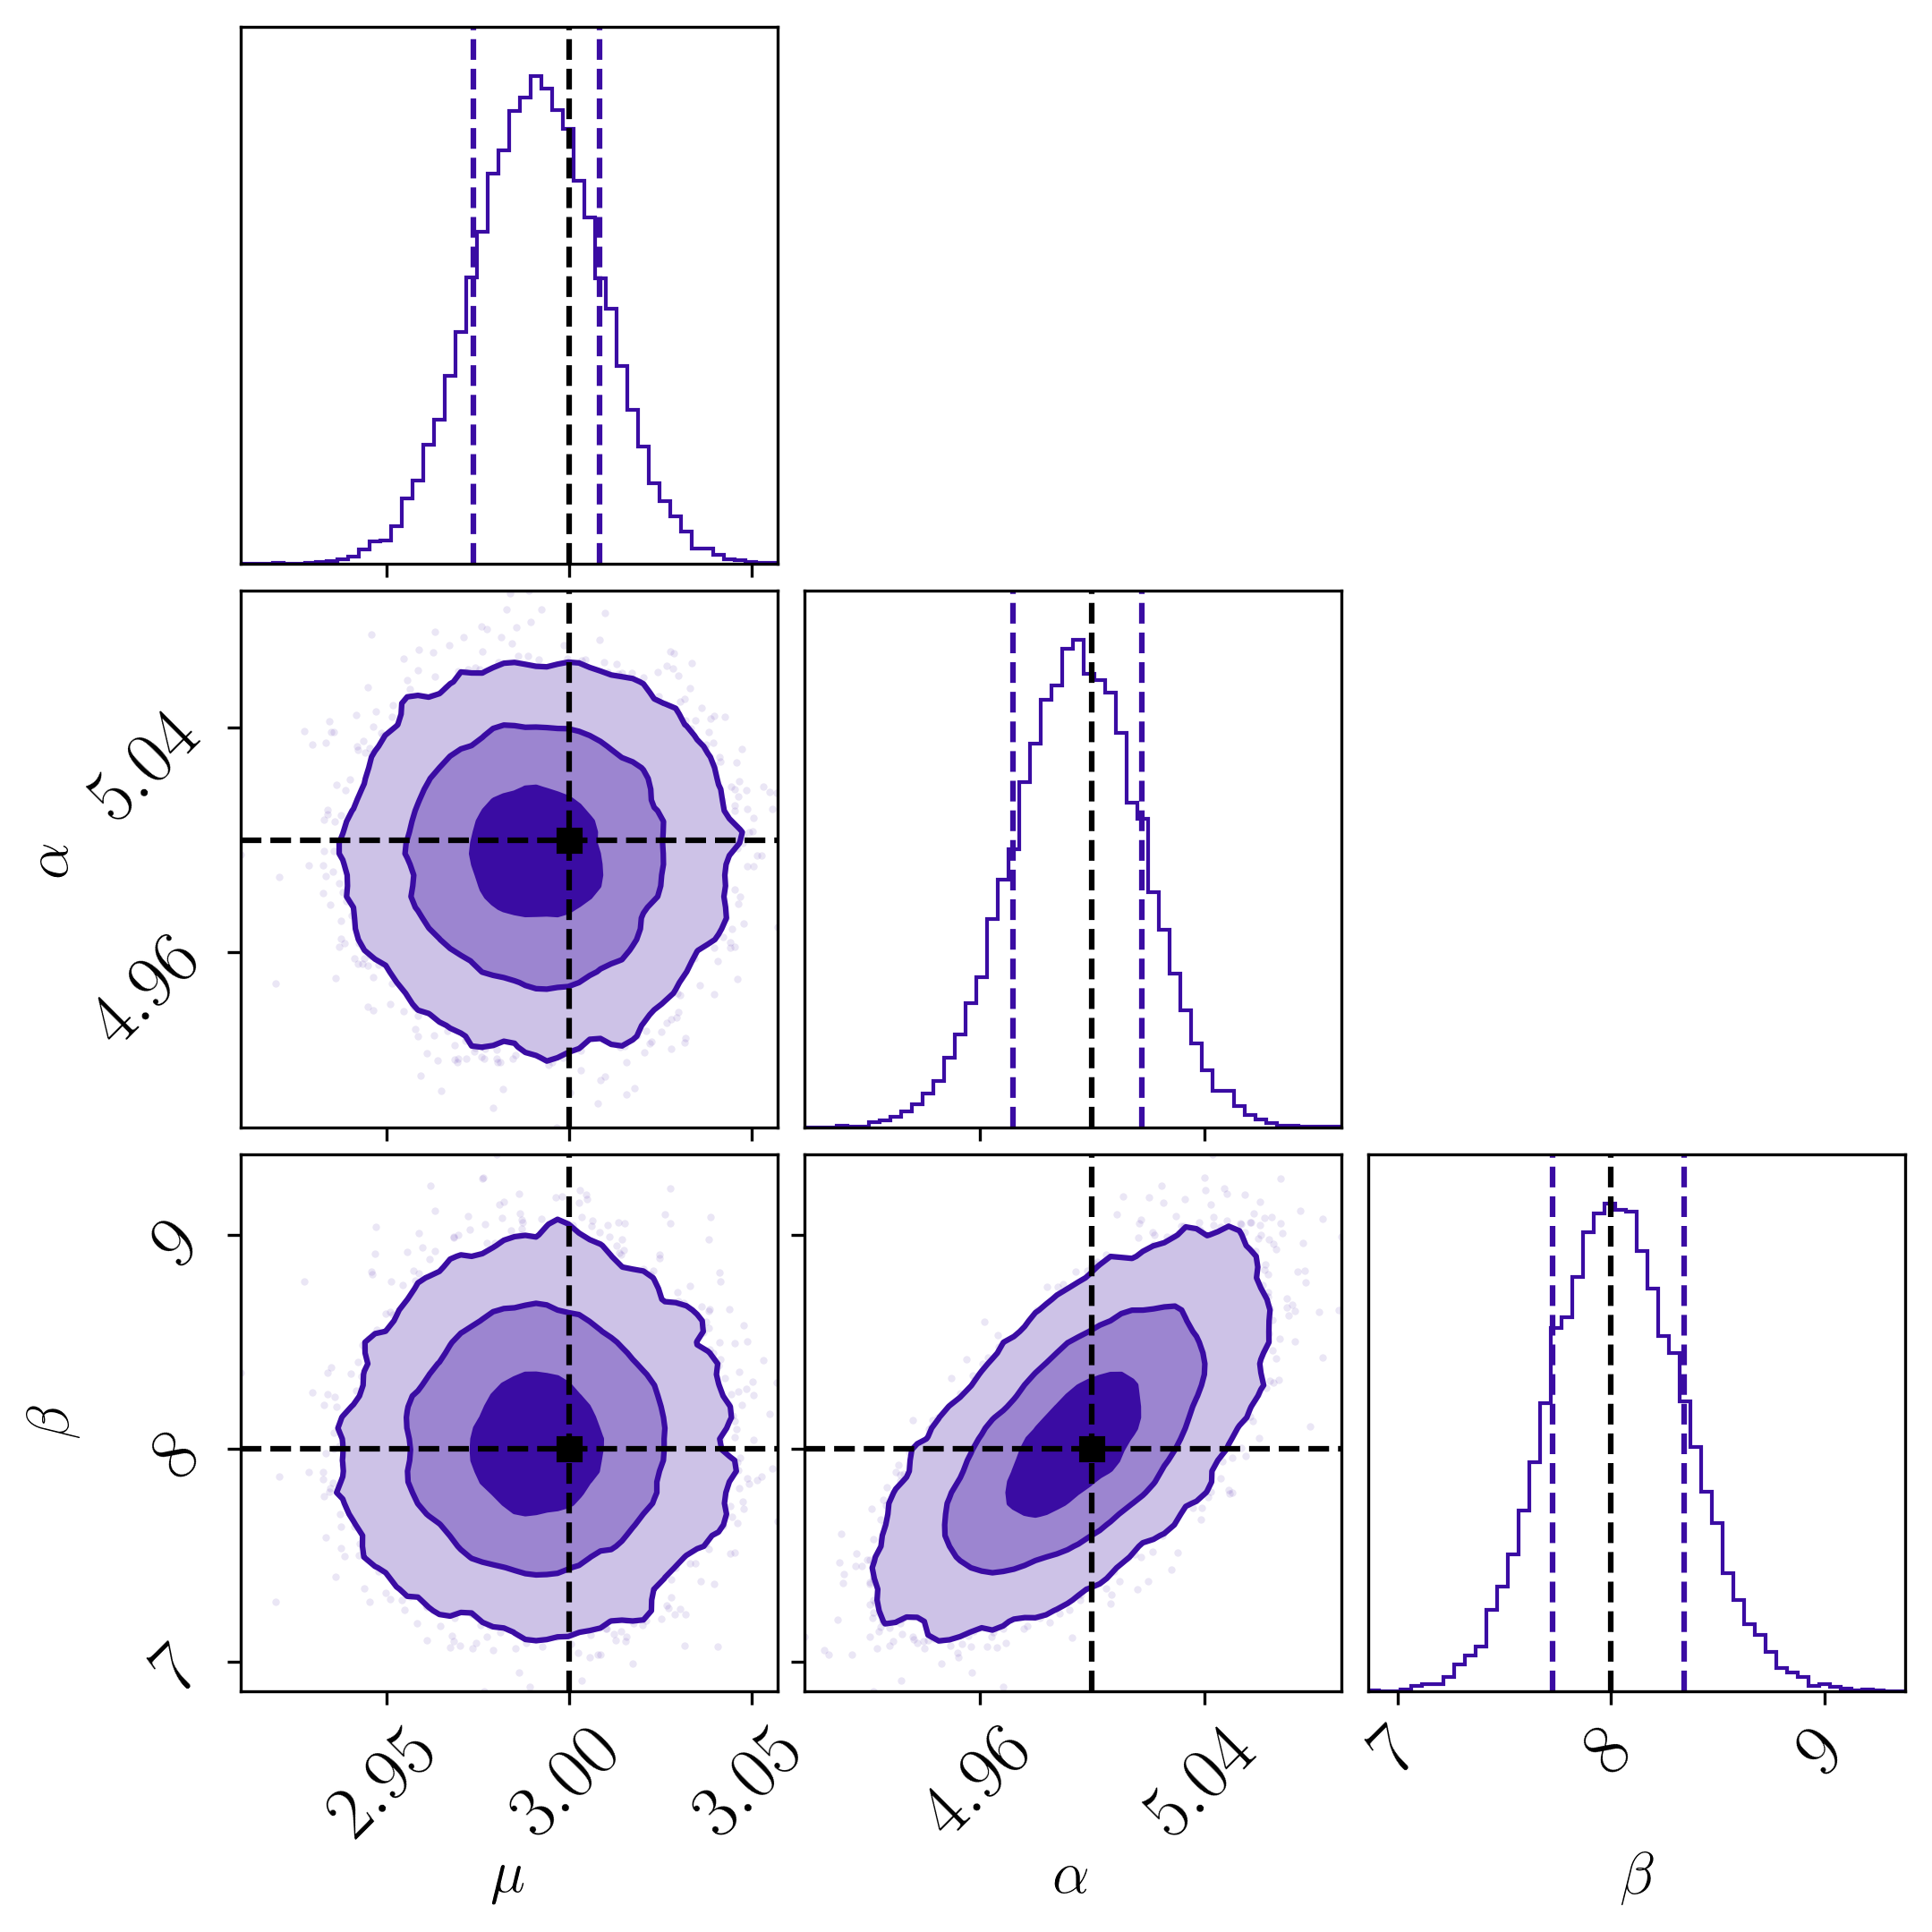

In [10]:
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = result_hybrid_pt.plot_corner(
        parameters=dict(
            mu=mu_true,
            alpha=alpha_true,
            beta=beta_true
        ),
        titles=False,
        color=HYBRID_COLOR,
        truth_color="black"
    )

fig

## With Dynesty Only

In [11]:
label_nest_only = "misspecified_dynesty-only"
outdir_nest_only = "./misspecified/misspecified_dynesty-only" 

generalized_gaussian_likelihood = GeneralizedNormalLikelihood(data)
priors_nest_only = dict(
    mu=bilby.core.prior.Uniform(minimum=0,maximum=5, latex_label=r"$\mu$"),
    alpha=bilby.core.prior.Uniform(minimum=0,maximum=10 * np.sqrt(2), latex_label=r"$\alpha$"),
    beta=bilby.core.prior.Uniform(minimum=0,maximum=10, latex_label=r"$\beta$")
)

nlive = 500

# And run sampler
result_nest_only = bilby.run_sampler(
    likelihood=generalized_gaussian_likelihood, priors=priors_nest_only, sampler='dynesty', npoints=nlive,
    walks=10, outdir=outdir_nest_only, label=label_nest_only)

08:20 bilby INFO    : Running for label 'misspecified_dynesty-only', output will be saved to './misspecified/misspecified_dynesty-only'
08:20 bilby INFO    : Search parameters:
08:20 bilby INFO    :   mu = Uniform(minimum=0, maximum=5, name=None, latex_label='$\\mu$', unit=None, boundary=None)
08:20 bilby INFO    :   alpha = Uniform(minimum=0, maximum=14.142135623730951, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
08:20 bilby INFO    :   beta = Uniform(minimum=0, maximum=10, name=None, latex_label='$\\beta$', unit=None, boundary=None)
08:20 bilby INFO    : Single likelihood evaluation took 4.397e-04 s


0it [00:00, ?it/s]

08:20 bilby INFO    : Checkpoint every check_point_delta_t = 600s
08:20 bilby WARNING : Using cached result
08:21 bilby INFO    : Summary of results:
nsamples: 8256
ln_noise_evidence:    nan
ln_evidence: -23674.475 +/-  7.024
ln_bayes_factor:    nan +/-  7.024



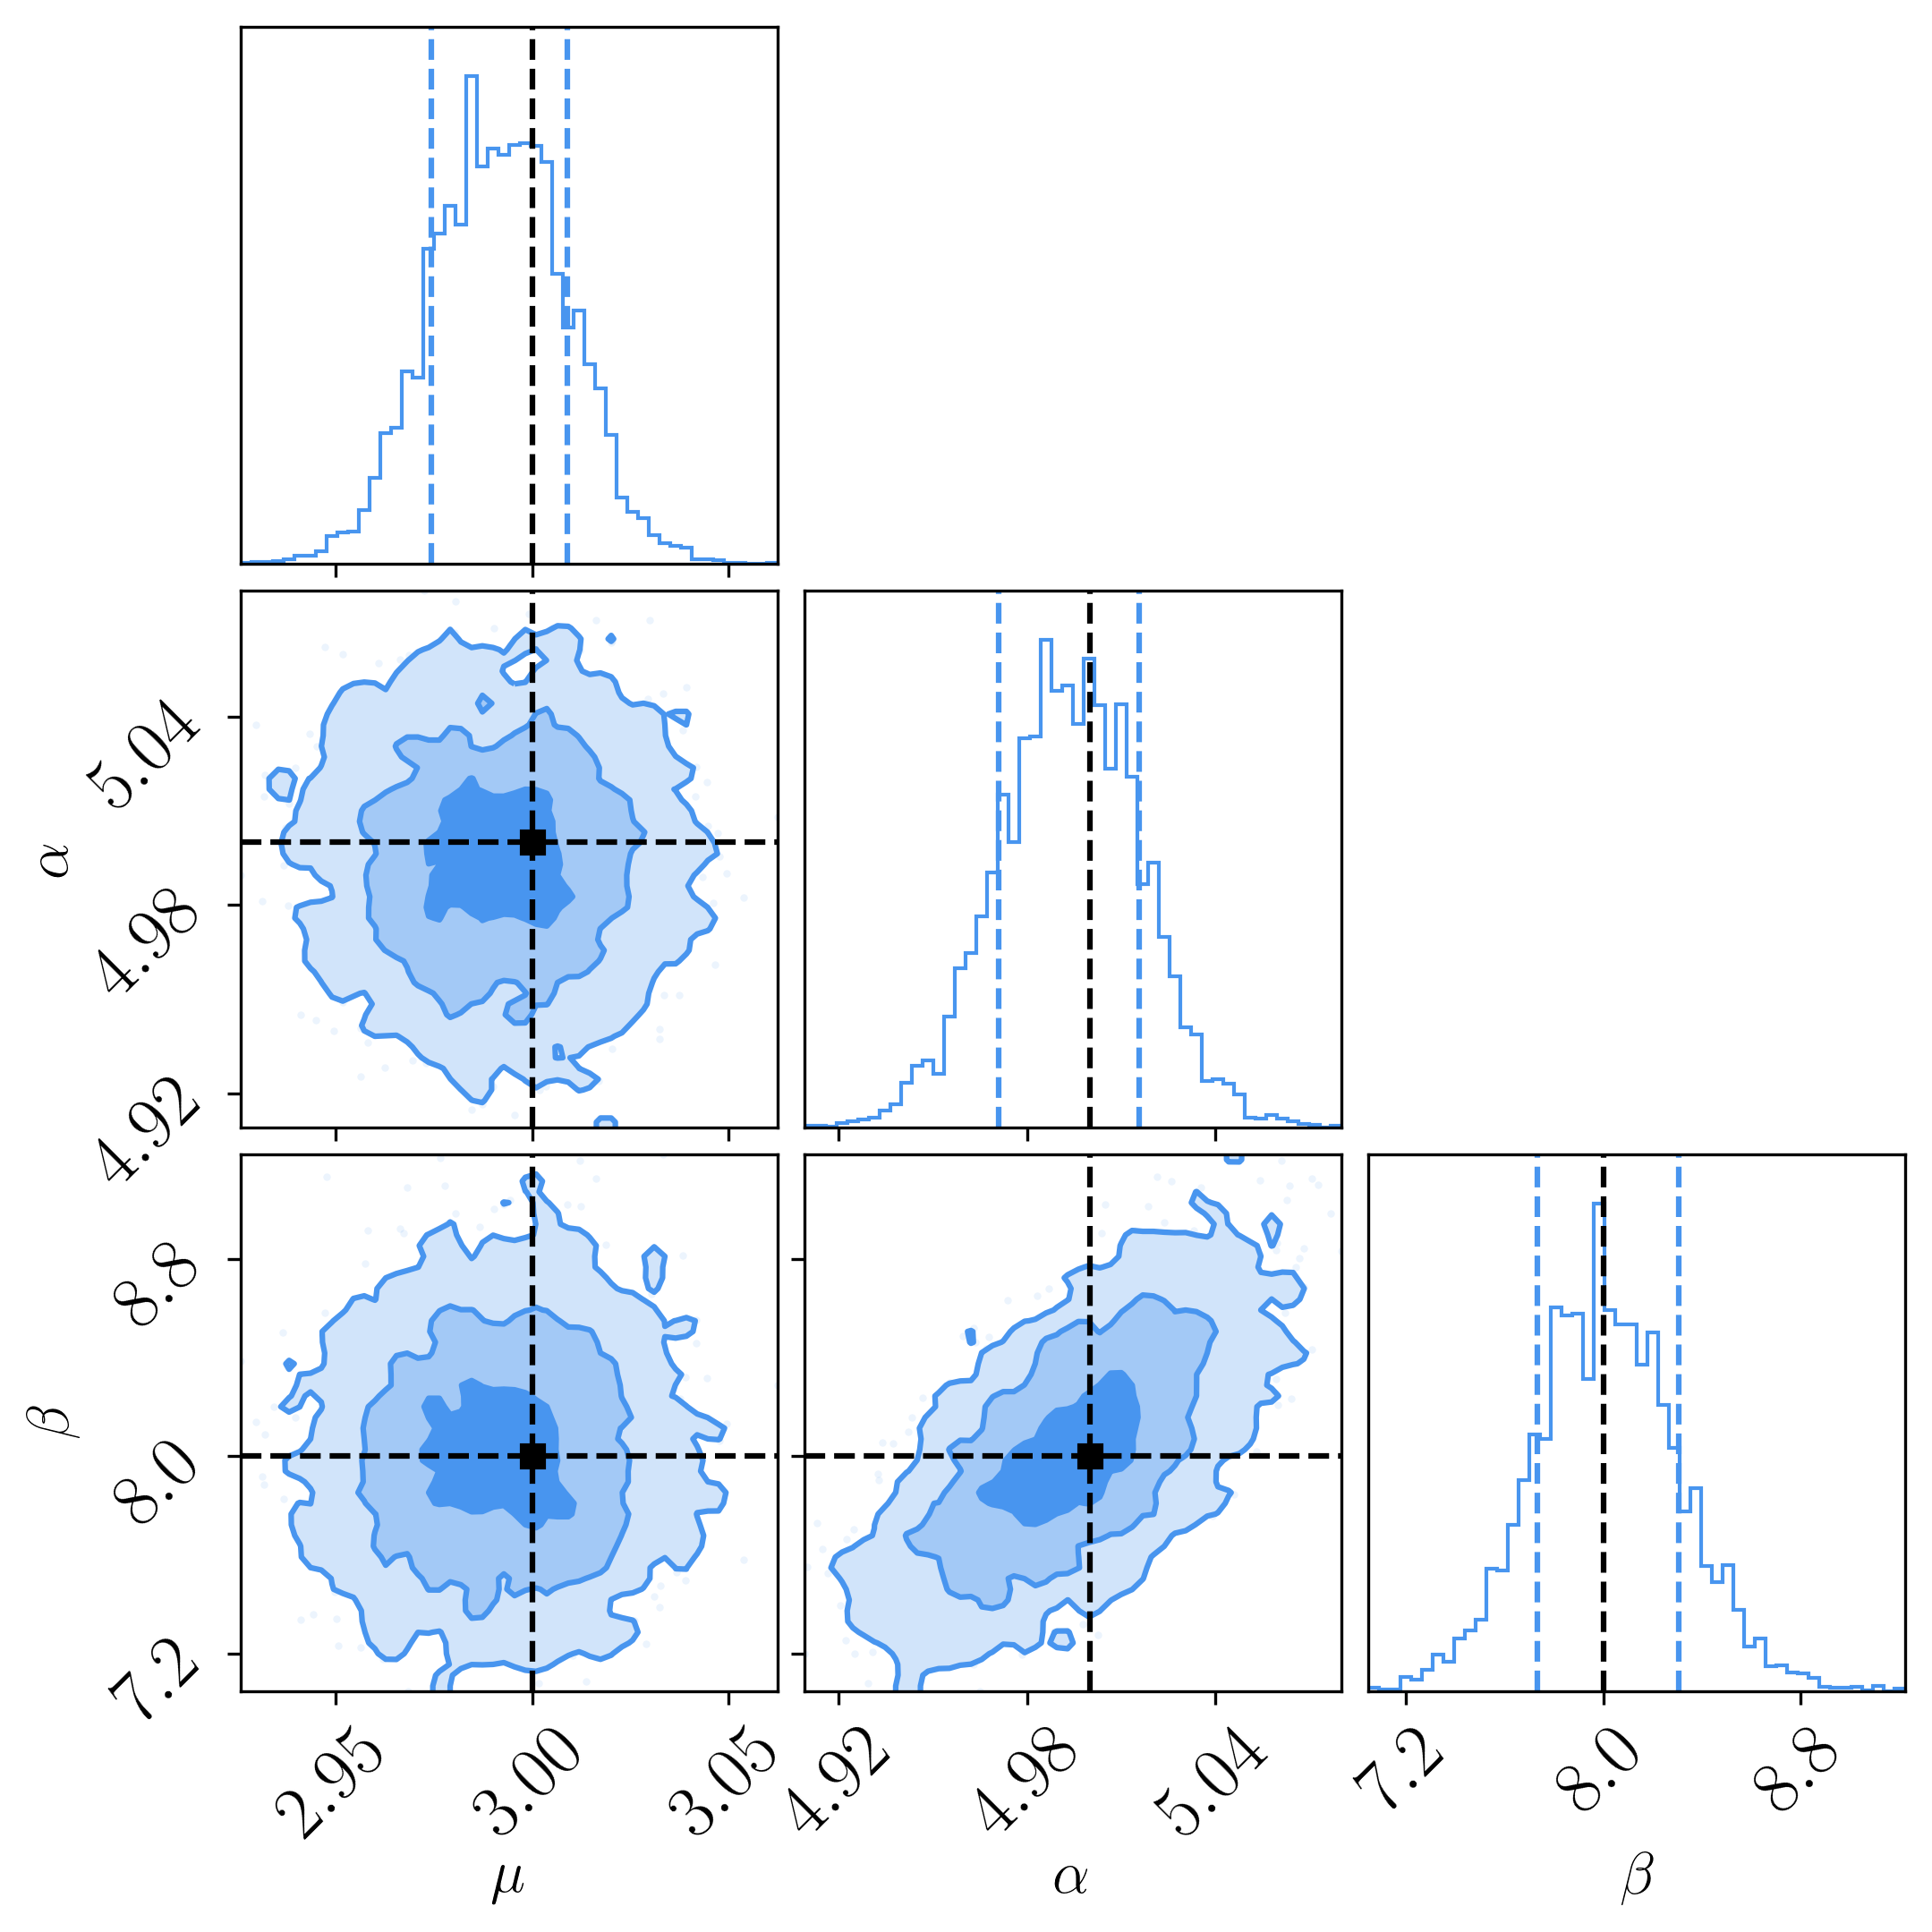

In [12]:
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = result_nest_only.plot_corner(
        parameters=dict(
            mu=mu_true,
            alpha=alpha_true,
            beta=beta_true
        ),
        titles=False,
        labels=[r"$\mu$", r"$\alpha$", r"$\beta$"],
        color=COMP_COLOR,
        truth_color="black"
    )

fig

# Comparison

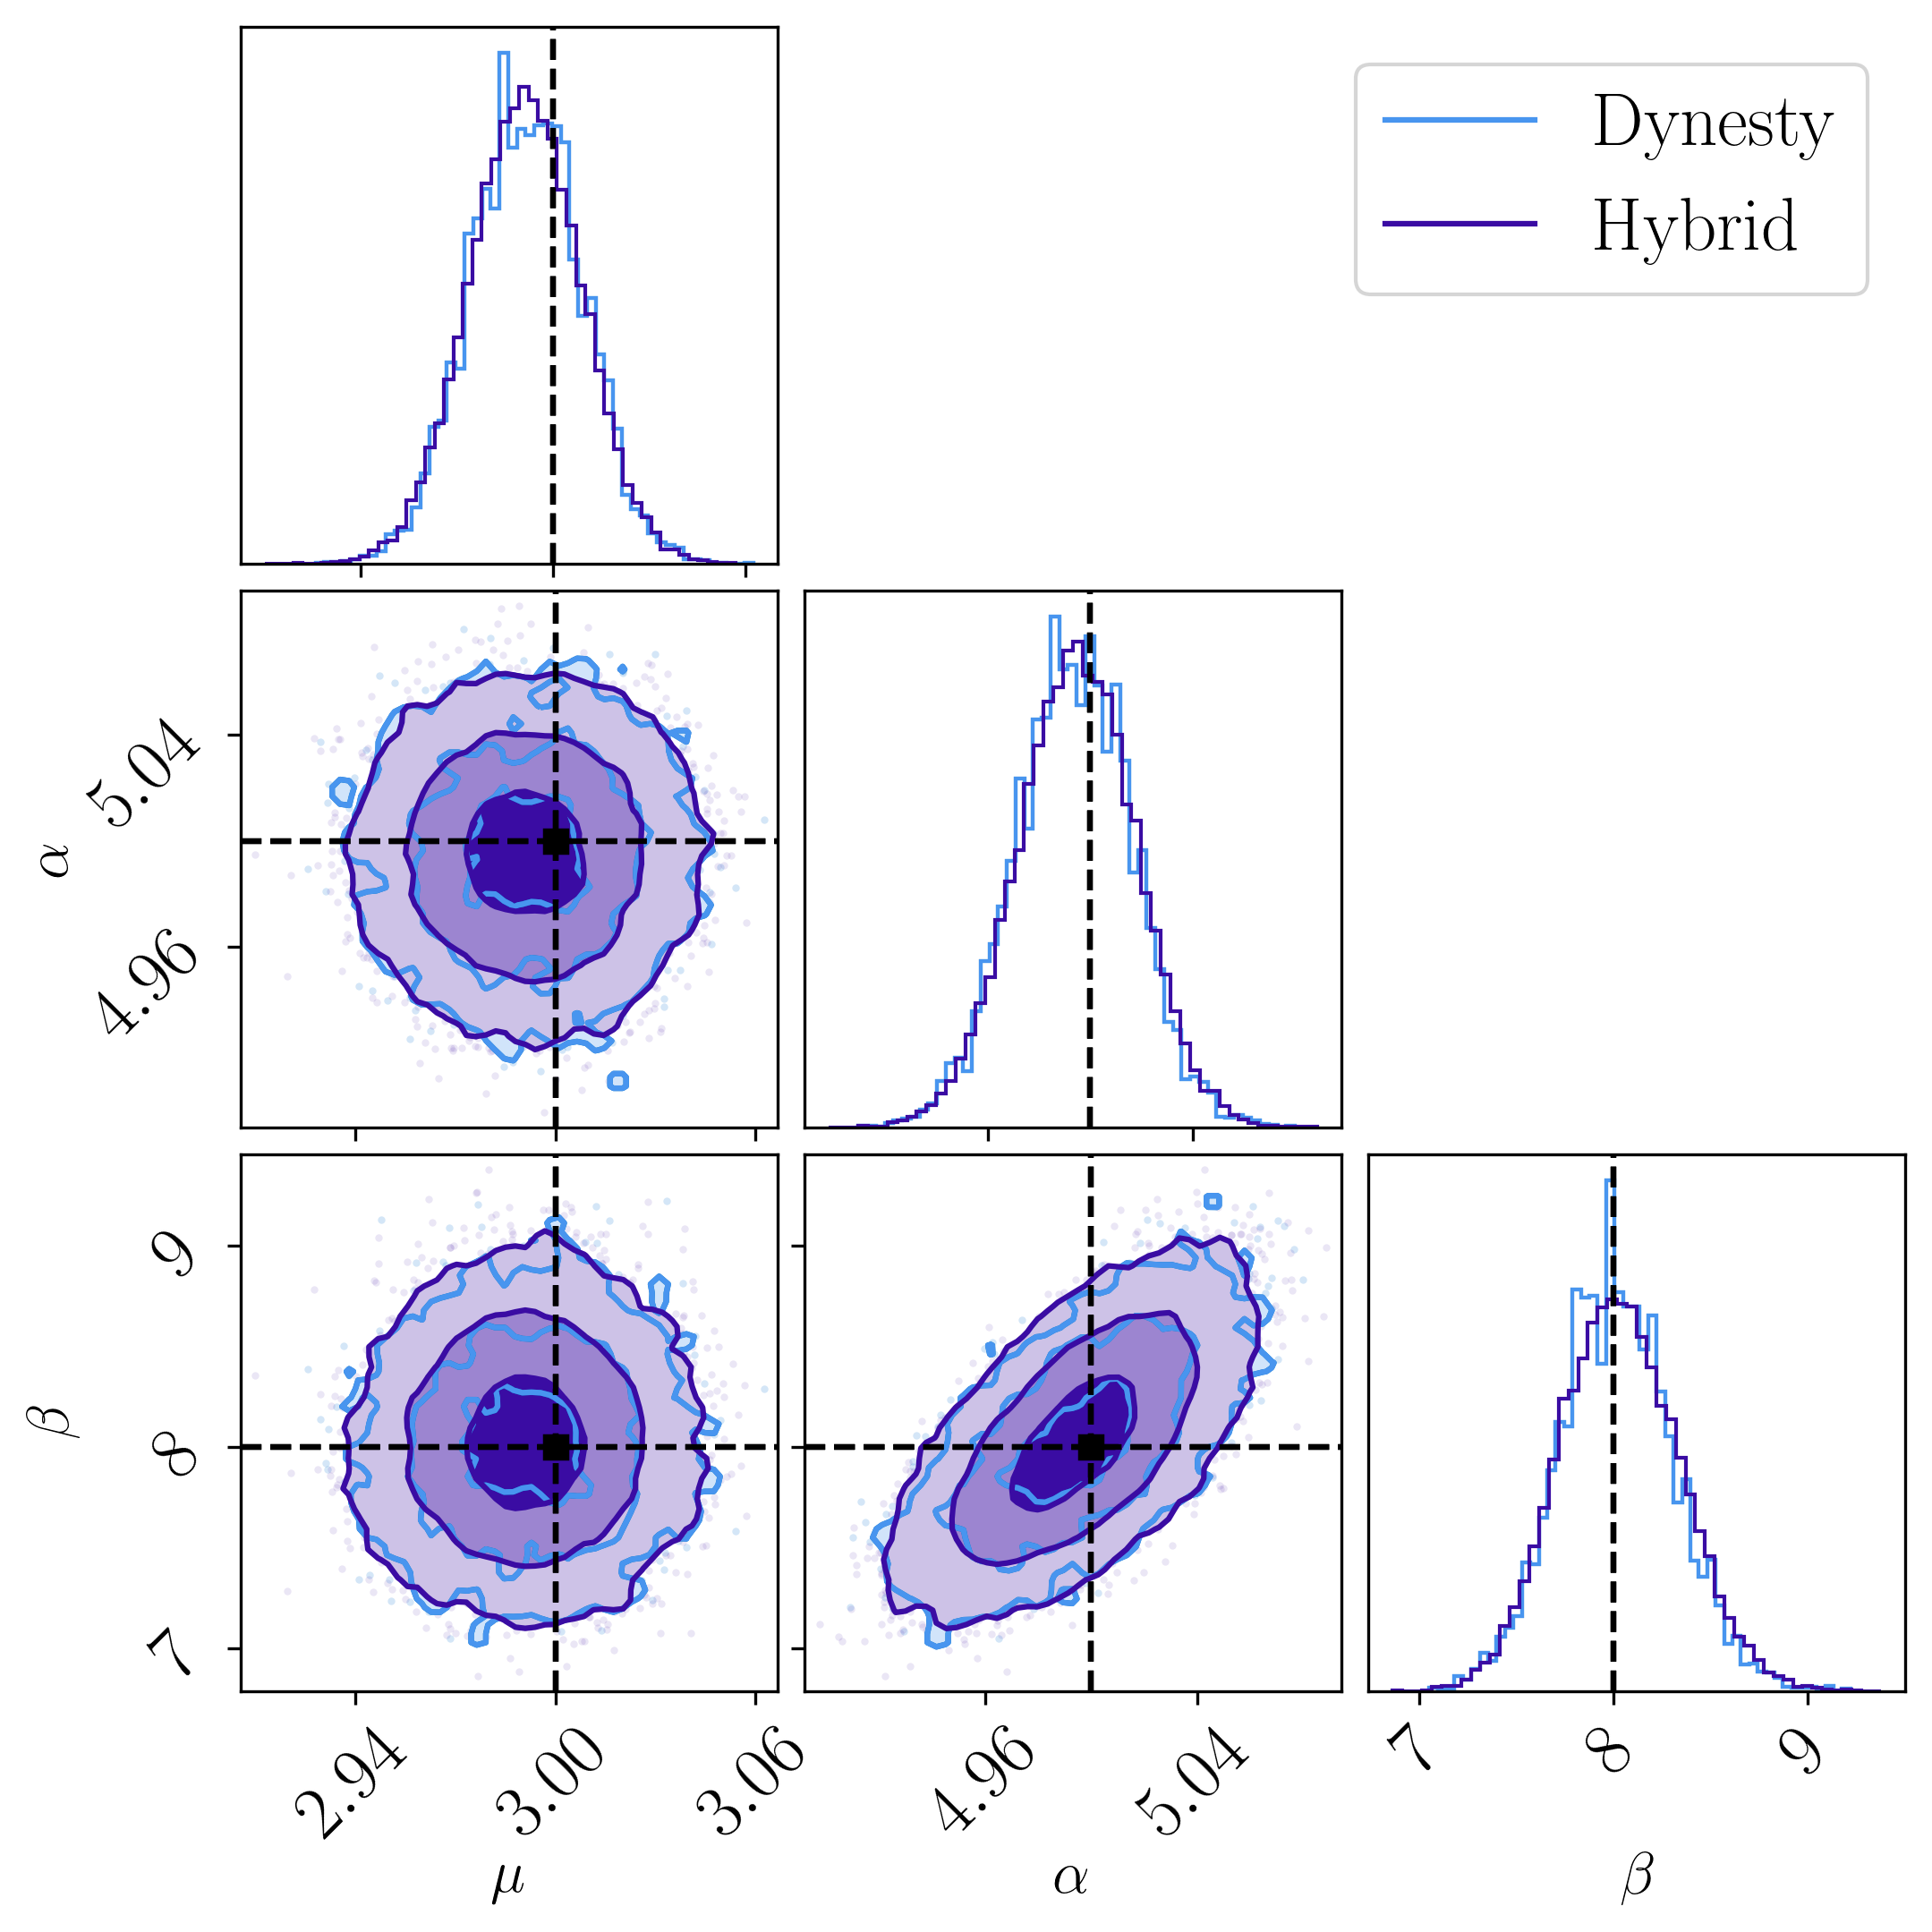

In [13]:
## Combined Corner plot of dynesty-only, hybrid results
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = bilby.core.result.plot_multiple(
        [result_nest_only, result_hybrid_pt],
        labels=["Dynesty", "Hybrid"],
        colours=[COMP_COLOR, HYBRID_COLOR],
        titles=False,
        truth_color="black",
        parameters=dict(
            mu=mu_true,
            alpha=alpha_true,
            beta=beta_true
        ),
        quantiles = None
    )

axes = fig.get_axes()
axes[2].legend(
    [ mpl.lines.Line2D([], [], color=COMP_COLOR), mpl.lines.Line2D([], [], color=HYBRID_COLOR) ],
    [ "Dynesty", "Hybrid" ]
)

fig.savefig("./toy-model_misspecified_comparison.pdf", bbox_inches='tight')


## Plot Sampler Evolution

/Users/newolfe/tgr-hybrid-sampling/toy.py:129: RuntimeWarning: divide by zero encountered in double_scalars
  return sigma / np.exp(gammaln(3 / beta) - gammaln(1 / beta))**0.5
/Users/newolfe/tgr-hybrid-sampling/toy.py:129: RuntimeWarning: invalid value encountered in double_scalars
  return sigma / np.exp(gammaln(3 / beta) - gammaln(1 / beta))**0.5
/Users/newolfe/tgr-hybrid-sampling/toy.py:129: RuntimeWarning: overflow encountered in exp
  return sigma / np.exp(gammaln(3 / beta) - gammaln(1 / beta))**0.5


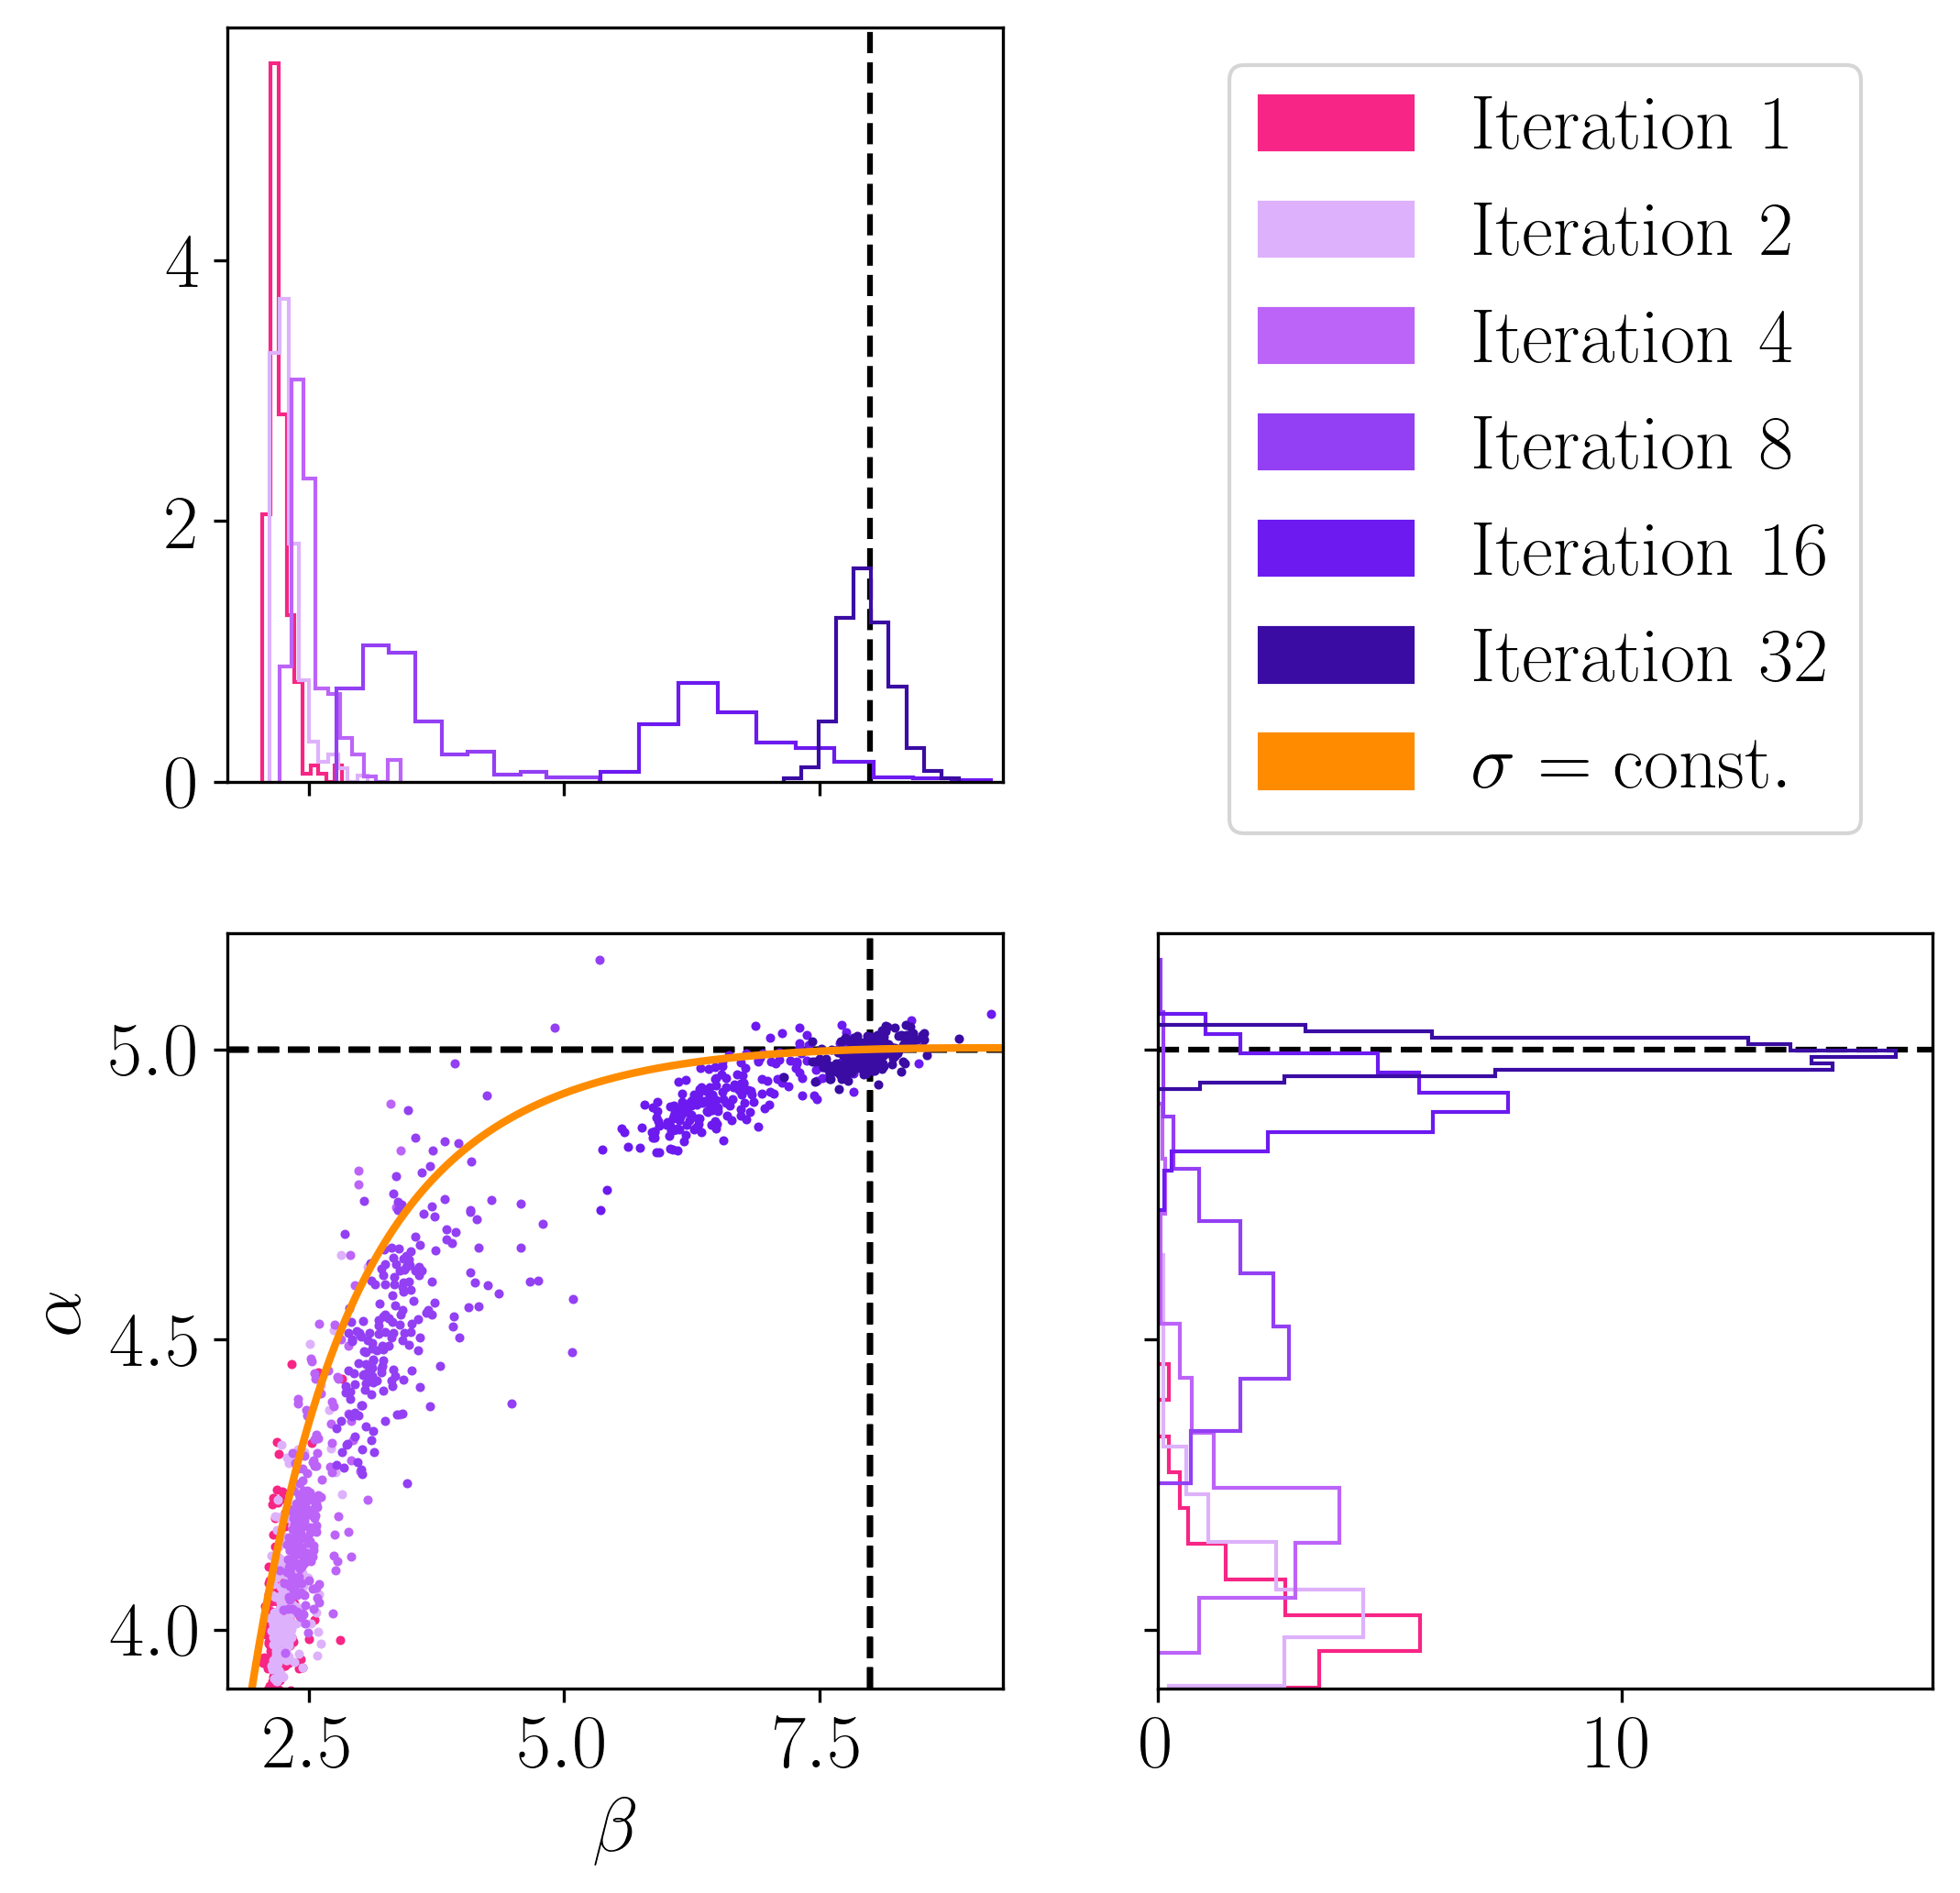

In [14]:
import dill

with open("./misspecified/misspecified_ptemcee-step/misspecified_ptemcee-step_checkpoint_resume.pickle", "rb") as f:
    pt_resume = dill.load(f)

iterations = np.array([1, 2, 4, 8, 16, 32])

fig, axes = plot_single_evolution(
    hybrid_result = result_hybrid_pt, hybrid_resume = pt_resume, 
    xparam = "beta", yparam = "alpha",
    xlabel = r"$\beta$", ylabel = r"$\alpha$", 
    xtrue = beta_true, ytrue = alpha_true,
    iterations = iterations - 1
)

beta_idx = result_hybrid_pt.search_parameter_keys.index("beta")
min_beta = pt_resume["chain_array"][:,:,beta_idx].min()
max_beta = pt_resume["chain_array"][:,:,beta_idx].max()
test_beta = np.linspace(min_beta, max_beta, 1000)

axes[1,0].plot(
    test_beta, [ sigma_to_alpha(sigma_true, beta = b) for b in test_beta ],
    color = "#FF8C00", linewidth=2
)
axes[1,0].set_xlim(1.7, 9.3)
axes[1,0].set_ylim(3.90, 5.2)

axes[0,1].legend(
    [ mpl.patches.Patch(facecolor=c, edgecolor=c) for c in [HYBRID_INIT_COLOR] + HYBRID_EVOL_COLORS[:len(iterations) - 1] ] + [ mpl.patches.Patch(facecolor="#FF8C00", edgecolor="#FF8C00") ],
    [ f"Iteration %d" % it for it in iterations ] + [ r"$\sigma = \mathrm{const.}$" ],
    loc = "upper center"
)

fig.savefig("./corner.pdf", bbox_inches="tight")


## Trace Plots

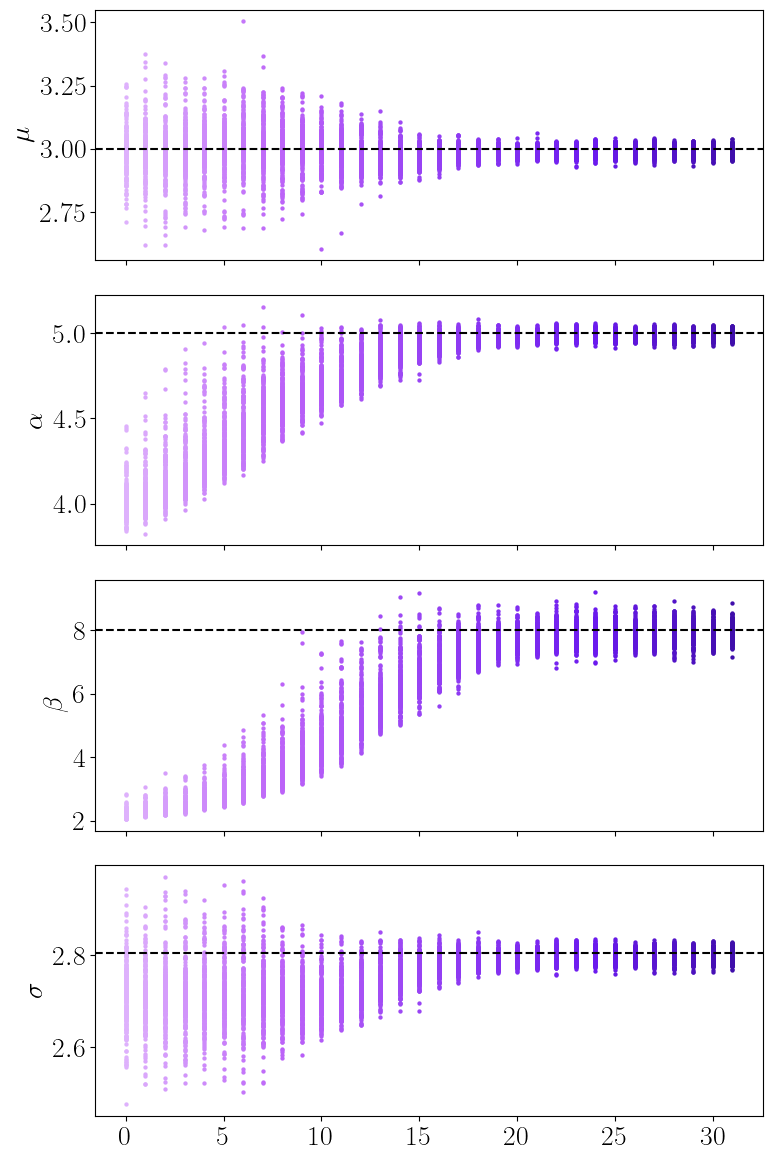

In [15]:
nmax = 32

hybrid_colors_rgb = [ mpl.colors.to_rgb(c) for c in HYBRID_EVOL_COLORS ]
cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_purple", hybrid_colors_rgb)

fig, axes = plt.subplots(figsize=(8,12),nrows=4,ncols=1,dpi=100, sharex=True)

for ax, param_idx, latex_label, true_val in zip(axes.flat, [0, 1, 2], [r"$\mu$", r"$\alpha$", r"$\beta$"], [mu_true, alpha_true, beta_true]):        
    for i in range(nmax):
        c = cmap( i/nmax )
        ax.scatter( np.tile(i, (nwalkers,1)), pt_resume["chain_array"][:,i,param_idx].flatten(), s=4.5, color=c)

    ax.set_ylabel(latex_label)
    ax.axhline(y=true_val, linestyle="--", color="black")

for i in np.arange(nmax):
    sigma_vals = np.zeros(nwalkers)
    c = cmap( i/nmax )
    for j in range(nwalkers):
        sigma_vals[j] = alpha_to_sigma( pt_resume["chain_array"][j,i,1], beta=pt_resume["chain_array"][j,i,2] )
    
    axes[-1].scatter(
        np.tile(i, (nwalkers,1)), sigma_vals, 
        s=4.5, color=c
    )

axes[-1].axhline(y=sigma_true, linestyle="--", color="black")
axes[-1].set_ylabel(r"$\sigma$")

plt.tight_layout()

fig.savefig("./misspecified_trace.pdf", bbox_inches="tight")



(<Figure size 3600x2400 with 1 Axes>,
 <AxesSubplot:xlabel='$x$', ylabel='$P(x)$'>)

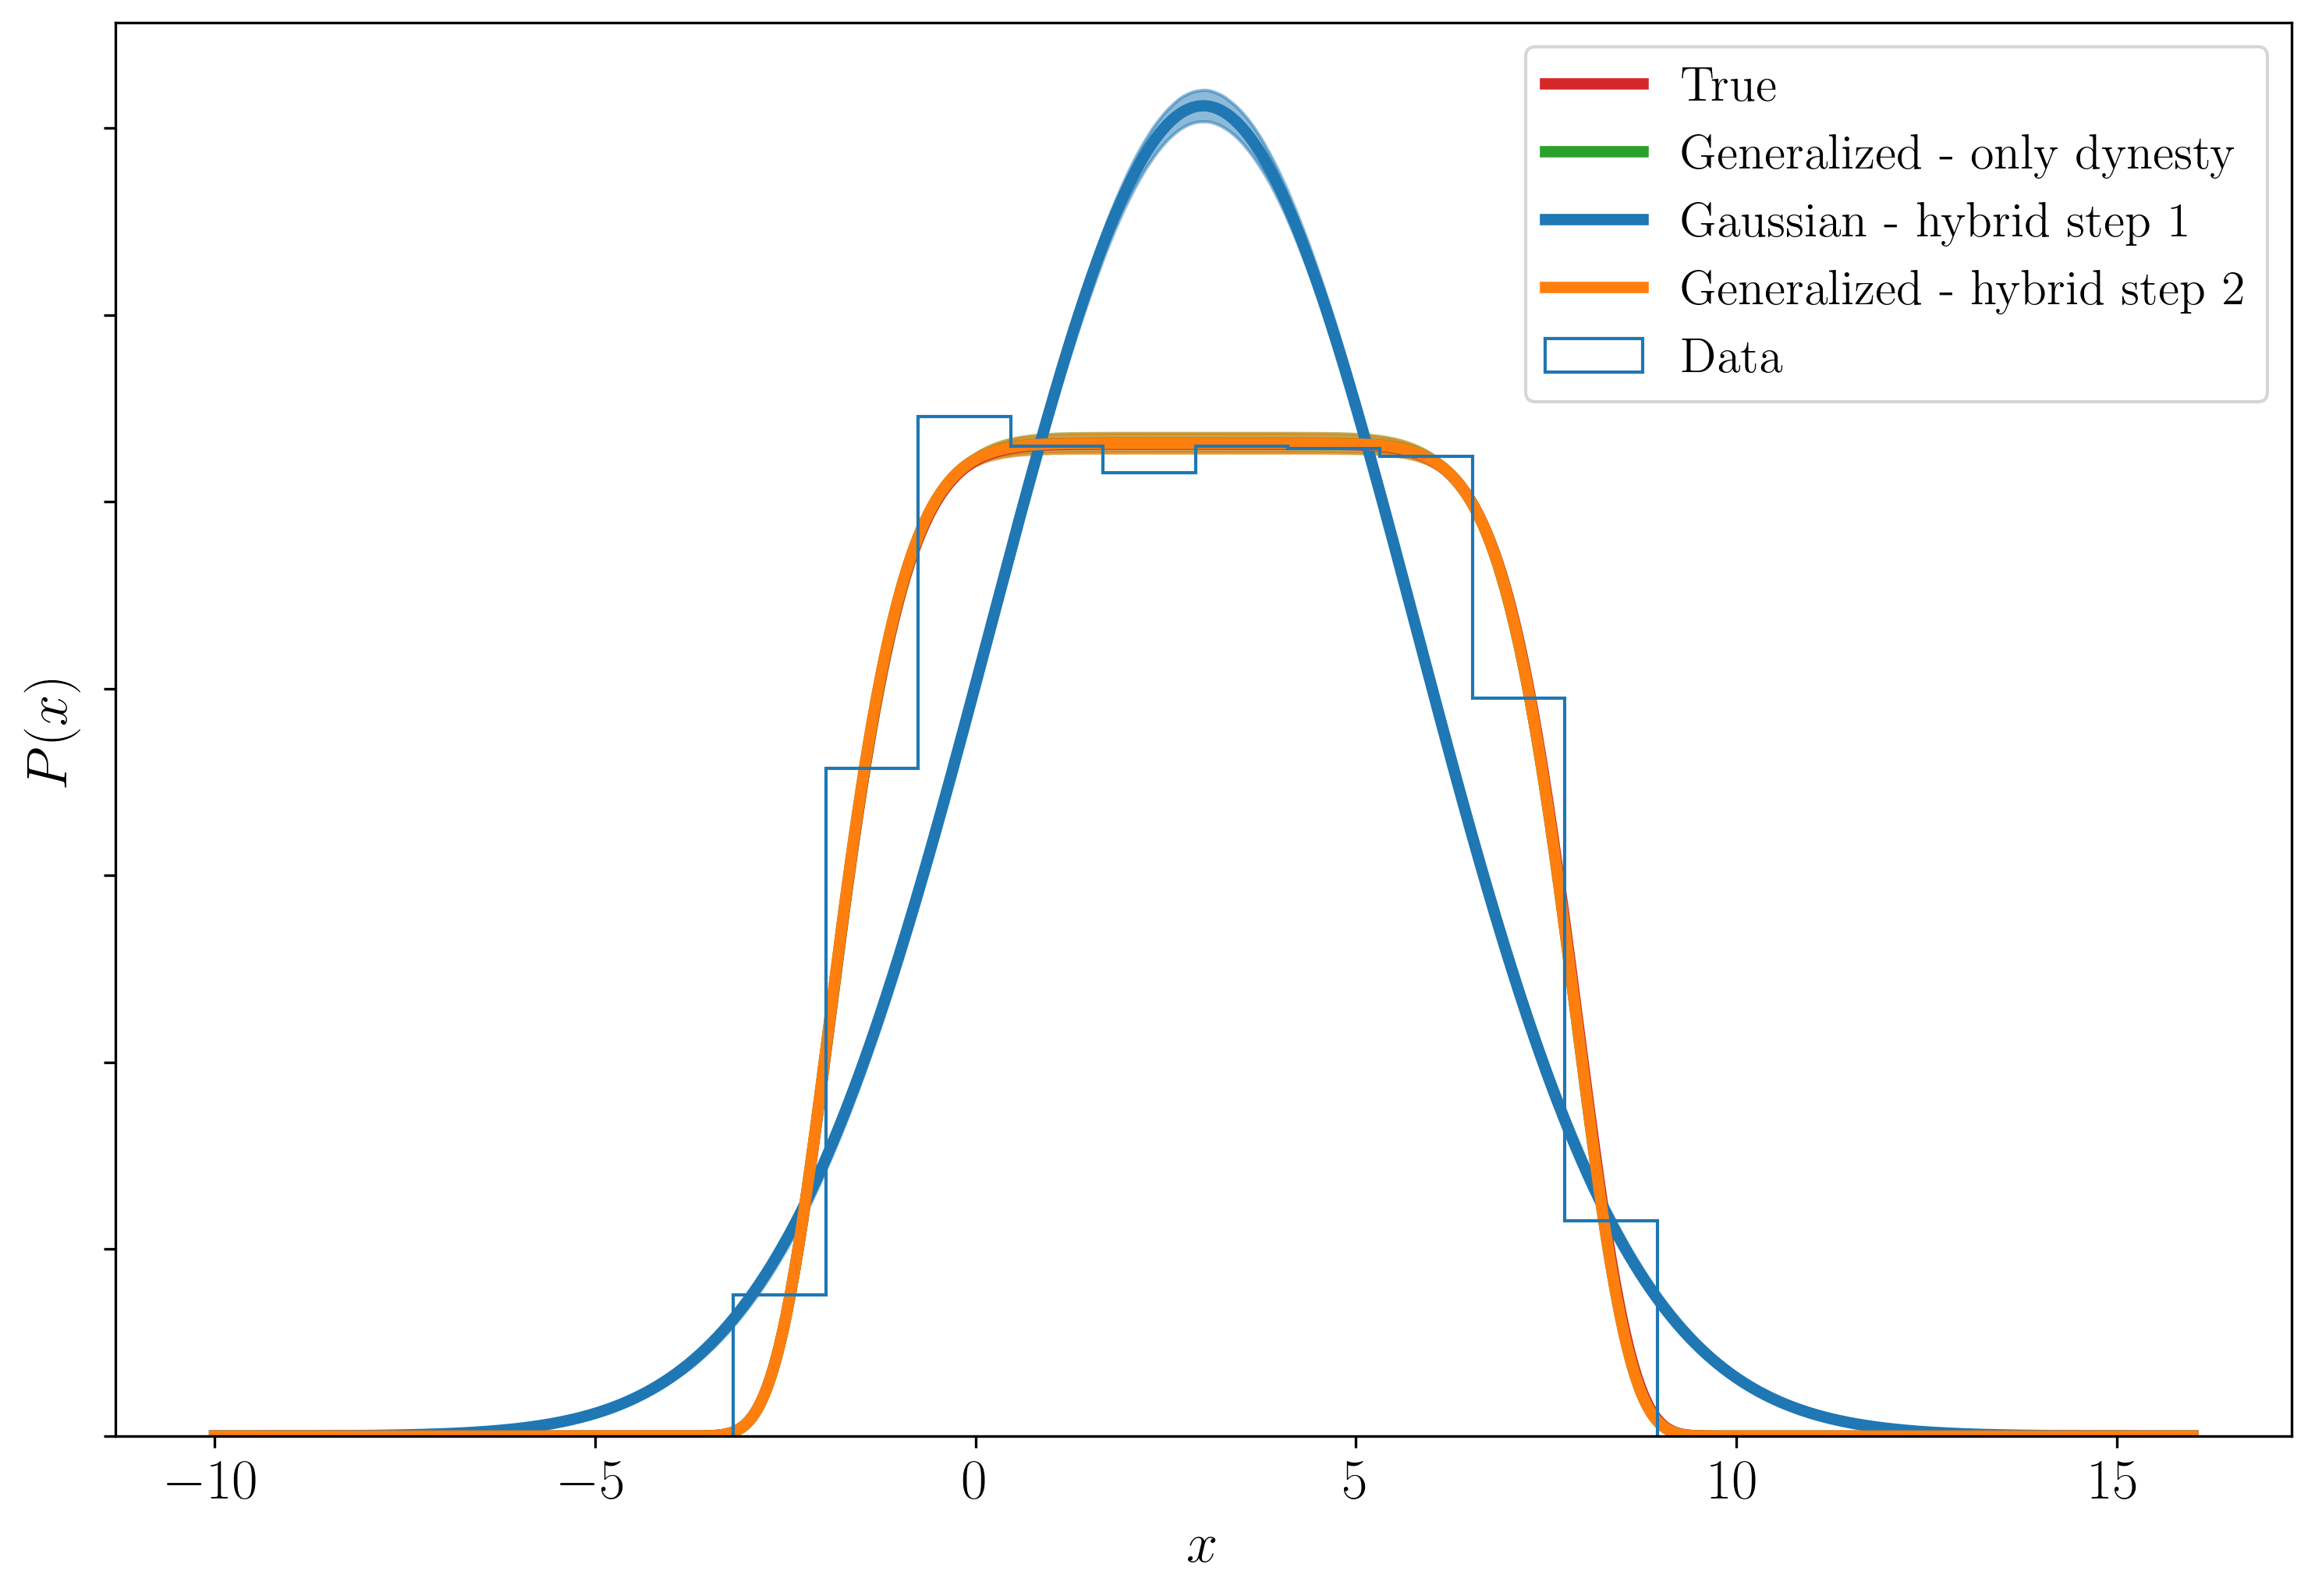

In [ ]:
plot_posterior_predictive_distribution(
    truth = (mu_true, alpha_true, beta_true), 
    data = data, 
    hybrid_dynesty_samples = result_hybrid_nest.samples, 
    hybrid_ptemcee_samples = result_hybrid_pt.samples, 
    dynesty_samples = result_nest_only.samples
)